# Comparing the EU and the US

In [41]:
from matplotlib.pylab import plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib import pyplot, lines
from matplotlib.patches import Patch
import matplotlib

from scipy.stats import ttest_ind



import pandas as pd
import numpy as np

import seaborn as sns

import datetime 


%matplotlib inline

# Parameters

In [2]:
us_peak_model_dataset = '../data/processed/peak_model_ctp_covid.csv'
countries_peak_model_dataset = '../data/processed/peak_model_owid_covid.csv'

# Load and Filter the Datasets

In [1236]:
us = pd.read_csv(us_peak_model_dataset, parse_dates=['date'])

us['region'] = 'us'

us.shape, us.state.nunique(), us['date'].max(), us.columns

((7027, 22),
 51,
 Timestamp('2020-07-16 00:00:00'),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'state', 'new_cases', 'new_deaths', 'population',
        'google_mobility_level', 'google_mobility_level_by_pop',
        'new_cases_rolling_mean', 'new_deaths_rolling_mean',
        'google_mobility_level_rolling_mean', 'new_cases_rolling_mean_rel',
        'new_deaths_rolling_mean_rel', 'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax', 'region'],
       dtype='object'))

In [4]:
countries = pd.read_csv(countries_peak_model_dataset, parse_dates=['date']).rename(columns={'country':'state'})

countries.shape, countries.state.nunique(), countries.date.max(), countries.columns

((34811, 25),
 207,
 Timestamp('2020-07-14 00:00:00'),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'country_id', 'state', 'country_code', 'continent', 'region',
        'new_cases', 'new_deaths', 'population', 'google_mobility_level',
        'google_mobility_level_by_pop', 'new_cases_rolling_mean',
        'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
        'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
        'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax'],
       dtype='object'))

In [5]:
eu_countries = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia','Cyprus', 'Czech Republic', 'Denmark', 
    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 
    'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'
]

eu = countries[countries['state'].isin(eu_countries)]
eu.shape, eu.columns

((4744, 25),
 Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
        'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
        'country_id', 'state', 'country_code', 'continent', 'region',
        'new_cases', 'new_deaths', 'population', 'google_mobility_level',
        'google_mobility_level_by_pop', 'new_cases_rolling_mean',
        'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
        'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
        'google_mobility_level_rolling_mean_rel',
        'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
        'google_mobility_level_rolling_mean_stage_day',
        'new_cases_rolling_mean_cummax'],
       dtype='object'))

## Combine Countries and US Datasets

In [6]:
# Rename country as state and combine.
df = pd.concat([countries.rename(columns={'country': 'state'}), us], ignore_index=True, sort=False).sort_values(by=['state', 'date'])
df.shape, df.state.nunique(), df.aggregation.nunique()

((41734, 25), 258, 287)

## Eliminate aggregations without mobility data

In [1213]:
with_mobility_data = df.groupby('aggregation').apply(lambda g: g['google_mobility_level_rolling_mean'].any())

df = df[df['aggregation'].isin(with_mobility_data[with_mobility_data].index)]

df.shape, df['state'].nunique()

((32463, 32), 183)

In [1214]:
df['state'].unique()

array(['Afghanistan', 'Alabama', 'Alaska', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Arizona', 'Arkansas', 'Aruba',
       'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'California', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Chile', 'Colombia', 'Colorado', 'Connecticut',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czech Republic',
       'Delaware', 'Denmark', 'District of Columbia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Finland', 'Florida', 'France', 'Gabon', 'Georgia',
       'Georgia (W. Asia)', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea-Bissau', 'Haiti', 'Hawaii', 'Honduras', 'Hungary', 'Idaho',
       'Illinois', 'India', 'Indiana', 'Indonesia', 'Iowa', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'J

# Lockdown Features

# Combination Model

## Visualising a Single Aggregation

In [1215]:
def simplify_number(n):
    
    if n < 1:
        label = '<1'
    else:
        label = '{:,}k'.format(int(n/1000)) if n>999 else '{:,}'.format(int(n))

    return label

def directional_label(n):
    
    arrow = '↑' if n>0 else '↓'
    
    return '{}{}'.format(arrow, simplify_number(n))

In [1216]:
stable_rate = 5
current_period_start = -14
previous_period_start = current_period_start*2

def plot_growth(ax, data, peak_label='cases/day', fill_colour = 'lavender', **kwargs):
    
    # Start at the first non-zero
    data = data.loc[data[data>0].index[0]:] 
    peak_date, peak_value = data.idxmax(), data.max()
    
    # The relative growth values
    rel = (data/peak_value)
    
    # The end date and current relative value.
    end_date, end_value = rel.index[-1], rel[-1]

    # Plot the growth line and fill the area beneath its curve.
    ax.plot(rel.index, rel, lw=1.5, c='k')
    ax.fill_between(rel.index, 0, rel, color=fill_colour, alpha=.25)
    
    

def highlight_growth_end_point(ax, growth_data, mobility_stages, **kwargs):
    
    current_value = growth_data[-1]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]

    # The current rate of change relative to post-lockdown.
    mean_growth = growth_data.loc[bounce_start_date:].mean()
    rel_growth = ((current_value/mean_growth)-1)*100
    rel_growth_label = ' {}%'.format(directional_label(rel_growth))
    
    # Mark and label the end point
    ax.plot(growth_data.index[-1], growth_data[-1]/growth_data.max(), marker='o', markersize=4, c='k')
    ax.text(growth_data.index[-1], growth_data[-1]/growth_data.max(), rel_growth_label, va='center', color='dimgrey', **kwargs)
    



In [1217]:
# def plot_lockdown(ax, rel_mobility, mobility_stages, h=.25, bottom=0, title='', **kwargs):

#     # The colours mapped to rel mobility values
#     transition_colours = ['white', 'skyblue', 'yellow', 'red']
#     cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)
#     colours = [cmap(v) for v in (1-rel_mobility).values]

#     # Current and last week's values
#     current_week, prev_week = rel_mobility[current_period_start:].mean(), rel_mobility[previous_period_start:current_period_start].mean()
#     growth_rate = int(100*(current_week-prev_week)/prev_week) if prev_week>0 else 0

#     # Plot the bars
#     ax.bar(rel_mobility.index, [h]*len(rel_mobility.index), bottom=bottom, width=2, color=colours)
    
#     # Plot the trace
#     ax.plot(rel_mobility.index, (rel_mobility*h)+bottom, lw=1, c='dimgrey')
    
#     # Label the current status
#     label_x = ax.get_xlim()[1]
#     label_y = (rel_mobility[-1]*h)+bottom    
    
#     if abs(growth_rate)<stable_rate:
#         growth_text = ' ↔{}%'.format(abs(growth_rate))
#     else:
#         growth_text = ' ↓{}%'.format(abs(growth_rate)) if growth_rate<0 else ' ↑{}%'.format(growth_rate)
    
#     ax.text(label_x, label_y, growth_text, color='dimgrey', **kwargs)

#     # The current mobility level line and label.
#     ax.plot(rel_mobility.index[-1], label_y, marker='o', markersize=3, c='k')
#     ax.axhline(label_y, color='k', ls=':', lw=.5)
    
#     current_level_text = 'Mobility @ {}%'.format(int(rel_mobility[-1]*100))
#     ax.text(ax.get_xlim()[0], label_y-.025, current_level_text, color='dimgrey', va='top', **kwargs)

#     # Highlight and label the peak/min
#     peak_date, peak_value = rel_mobility.idxmin(), rel_mobility.min()
#     ax.plot(peak_date, (peak_value*h)+bottom, marker='o', markersize=4, c='r')
#     ax.plot(peak_date, (peak_value*h)+bottom, marker='o', markersize=1, c='k')
    
#     peak_label = ' {}%'.format(int(peak_value*100))
#     # If the peak is below 45% then plot above the line
#     if peak_value<0.35: peak_y, peak_label_va = (peak_value*h)+bottom+.03, 'bottom'
#     else: peak_y, peak_label_va = (peak_value*h)-bottom-.03, 'top'

#     ax.text(peak_date, peak_y, peak_label, va=peak_label_va, ha='center', color='dimgrey', fontsize=kwargs['fontsize'])
    
#     # The lockdown start and end.
#     drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
#     bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]

#     ax.axvline(drop_start_date, color='k', ls=':', lw=.5)
#     ax.axvline(bounce_start_date, color='k', ls=':', lw=.5)
    
#     ax.text(drop_start_date, 1.75, ' {}'.format(drop_start_date.strftime("%b %d")), color='dimgrey', **kwargs)
#     ax.text(bounce_start_date, 1.75, ' {}'.format(bounce_start_date.strftime("%b %d")), color='dimgrey', **kwargs)

    
    
#     # Label the lockdown chart with the average lockdown level and duration
#     mean_lockdown_level = rel_mobility.loc[drop_start_date:bounce_start_date].mean()
#     lockdown_duration = len(rel_mobility.loc[drop_start_date:bounce_start_date])
#     ax.text(
#         drop_start_date+datetime.timedelta(days=2), h, 
#         '{:,}% x {}d'.format(int(mean_lockdown_level*100), lockdown_duration), 
#         color='dimgrey', va='top', ha='left', fontsize=kwargs['fontsize'])
    
#     mean_bounce_level = rel_mobility.loc[bounce_start_date:].mean()
#     bounce_duration = len(rel_mobility.loc[bounce_start_date:]*.9)
#     ax.text(
#         rel_mobility.index[-1], bottom+.01, 
#         '{:,}% x {}d '.format(int(mean_bounce_level*100), bounce_duration), 
#         color='dimgrey', ha='right', fontsize=kwargs['fontsize']*.9)



def plot_mobility(ax, mobility_data, h, bottom, **kwargs):

    # The colours mapped to rel mobility values
    transition_colours = ['white', 'skyblue', 'yellow', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("", transition_colours)
    colours = [cmap(v) for v in (1-mobility_data).values]

    # Plot the bars
    ax.bar(mobility_data.index, [h]*len(mobility_data.index), bottom=bottom, width=2, color=colours)
    
    # Plot the trace
    ax.plot(mobility_data.index, (mobility_data*h)+bottom, lw=1, c='k')
        
        
def highlight_mobility_peak(ax, mobility_data, h, bottom, y_offset=0.04, **kwargs):
    
    # Highlight and label the peak/min
    peak_date, peak_value = mobility_data.idxmin(), mobility_data.min()
    ax.plot(peak_date, (peak_value*h)+bottom, marker='o', markersize=4, c='r')
    ax.plot(peak_date, (peak_value*h)+bottom, marker='o', markersize=1, c='k')
    
    ax.text(peak_date, (peak_value*h)+bottom-y_offset, ' {}%'.format(int(100*peak_value)), color='dimgrey', ha='center', va='top', **kwargs)
    
    
def highlight_lockdown_start_end(ax, growth_data, mobility_stages, **kwargs):
    
    drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]
    
     # The relative growth at the start and end
    entry_rate = growth_data.loc[drop_start_date]/growth_data.max()
    exit_rate = growth_data.loc[bounce_start_date]/growth_data.max()

    ax.axvline(drop_start_date, color='k', ls=':', lw=.5)
    ax.axvline(bounce_start_date, color='k', ls=':', lw=.5)
    
    ax.text(drop_start_date, 1.75, '({}%) {} '.format(int(100*entry_rate), drop_start_date.strftime("%b %d")), color='dimgrey', ha='right', va='center', **kwargs)
    ax.text(bounce_start_date, 1.75, ' ({}%) {}'.format(int(100*exit_rate), bounce_start_date.strftime("%b %d")), color='dimgrey', va='center', **kwargs)


def highlight_during_after_mobility_levels(ax, mobility_data, mobility_stages, start_date, h, bottom, y_offset=0.01, **kwargs):
    
    # The lockdown start and end.
    drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]
    end_date = mobility_data.index[-1]
    
    # Mean levels during/after lockdown, adjusted to the correct cooords.
    mean_during = mobility_data.loc[drop_start_date:bounce_start_date].mean()
    mean_after = mobility_data.loc[bounce_start_date:].mean()
    
    during_days = (bounce_start_date-drop_start_date).days
    after_days = (end_date-bounce_start_date).days
    
    adj_mean_during = (mean_during*h)+bottom
    adj_mean_after = (mean_after*h)+bottom
    
    # Plot the guidelines
    ax.plot([start_date, drop_start_date], [adj_mean_during]*2, color='k', ls=':', lw=.5)  # During
    ax.plot([drop_start_date, bounce_start_date], [adj_mean_during]*2, color='k', ls='--', lw=1)  # During

    ax.plot([start_date, bounce_start_date], [adj_mean_after]*2, color='k', ls=':', lw=.5)  # After
    ax.plot([bounce_start_date, end_date], [adj_mean_after]*2, color='k', ls='--', lw=1)  # After
    
    # Label the during/after levels.
    ax.text(start_date, adj_mean_during-y_offset, 'Mean during: {}% ({}d)'.format(int(100*mean_during), during_days), va='top', color='dimgrey', **kwargs)
    ax.text(start_date, adj_mean_after+y_offset, 'Mean after: {}% ({}d)'.format(int(100*mean_after), after_days), va='bottom', color='dimgrey', **kwargs)

    

def highlight_mobility_end_point(ax, mobility_data, mobility_stages, h, bottom, **kwargs):
    
    current_value = mobility_data[-1]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]

    # The current rate of change relative to post-lockdown.
    mean_mobility = mobility_data.loc[bounce_start_date:].mean()
    rel_mobility = ((current_value/mean_mobility)-1)*100
    rel_mobility_label = ' {}%'.format(directional_label(rel_mobility))
    
    # Mark and label the end point
    ax.plot(mobility_data.index[-1], (mobility_data[-1]/mobility_data.max()*h)+bottom, marker='o', markersize=4, c='k')
    ax.text(mobility_data.index[-1], (mobility_data[-1]/mobility_data.max()*h)+bottom, rel_mobility_label, va='center', color='dimgrey', **kwargs)
    



In [1218]:
# def plot_stages(ax, growth_data, stages, **kwargs):
        
#     peak_value = growth_data.max()
    
#     # Add the growth stages
#     stage_start_dates = stages.reset_index().groupby(
#         stages.reset_index().columns[1]).first().reindex(['E', 'P', 'C', 'S']).dropna()

#     stage_start_dates['date'].map(
#         lambda start_date: ax.plot([start_date]*2, [0, growth_data[start_date]/peak_value], lw=.25, c='k'))

In [1219]:
def plot_annotations(ax, title, total_cases, total_deaths, total_lockdown_level, total_lockdown_days, **kwargs):
    
    # The title
    ax.set_title('{}\n{:,} cases/M, {:,} deaths/M, CFR ~ {}\nMobility: {}% x {}w'.format(
        title, 
        int(total_cases), 
        int(total_deaths),
        round(total_deaths/total_cases, 3),
        int((total_lockdown_level*100)/total_lockdown_days), total_lockdown_days//7
    ), loc='left', fontsize=int(kwargs['fontsize']*1.1))
    
    
    # Remove the axes spines and the y ticks
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    [t.set_visible(False) for t in ax.get_yticklabels()]

    ax.spines['bottom'].set_visible(True)


    # x-axis date locators and formatters
    locator = mdates.AutoDateLocator(maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    month_fmt = mdates.DateFormatter('%b')
    def m_fmt(x, pos=None): return month_fmt(x)[:3]

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        
    ax.tick_params(axis = 'x', which = 'major', width=1, length=5, labelsize=kwargs['fontsize'], labelcolor='dimgrey', color='dimgrey')


In [1220]:


# Assemble and plot the peak label (units/day plus date)
def draw_peak_label(ax, peak_date, peak_value, rel_peak_value, peak_label, y_offset=.05,  **kwargs):
    
    peak_value_text = simplify_number(peak_value)
    peak_date_text = peak_date.strftime("%b %d")
    
    peak_ha = 'center' if peak_date<datetime.datetime.strptime('01/05/2020', "%d/%m/%Y") else 'right'
    ax.text(peak_date, rel_peak_value+y_offset,
            ' {} {}\n ({}%) {}'.format(peak_value_text, peak_label, int(100*rel_peak_value), peak_date_text), 
            color='dimgrey', ha=peak_ha, **kwargs)


# Draw the peak line to the peak value.
def draw_peak_line(ax, bx, peak_date, rel_peak_value, h):
    ax.plot(peak_date, rel_peak_value, marker='o', markersize=4, c='r')
    ax.plot(peak_date, rel_peak_value, marker='o', markersize=1, c='k')
    ax.plot([peak_date]*2, [0, rel_peak_value], color='k', ls=':', lw=.5)
    bx.plot([peak_date]*2, [bx.get_ylim()[0], h], color='k', ls=':', lw=.5)  # Extend the peak line through the mobility chart
    

# Highlight the overall and lockdown peaks
def highlight_growth_peaks(ax, bx, growth_data, mobility_stages, h, peak_label, **kwargs):
    
    end_date = growth_data.index[-1]
    
    # The lockdown start and end.
    drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]
    
    # The lockdown peak
    lockdown_peak_date = growth_data.loc[drop_start_date:bounce_start_date].idxmax()
    lockdown_peak_value = growth_data.loc[drop_start_date:bounce_start_date].max()

    # The overall peak
    overall_peak_date = growth_data.idxmax()
    overall_peak_value = growth_data.max()
    
    # Highlight and label the overall peak
    draw_peak_line(ax, bx, overall_peak_date, 1, h)
    draw_peak_label(ax, overall_peak_date, overall_peak_value, 1, peak_label, **kwargs)
    
    # if the lockdown and overall peaks are different then highlight the lockdown peak
    if abs((overall_peak_date-lockdown_peak_date).days)>7:
        draw_peak_line(ax, bx, lockdown_peak_date, lockdown_peak_value/overall_peak_value, h)
        draw_peak_label(ax, lockdown_peak_date, lockdown_peak_value, lockdown_peak_value/overall_peak_value, peak_label, **kwargs)



def highlight_during_after_growth_levels(ax, growth_data, mobility_stages, start_date, peak_label, y_offset=.05, **kwargs):
    # The lockdown start and end.
    drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]
    end_date = growth_data.index[-1]
    
    mean_during = growth_data.loc[drop_start_date:bounce_start_date].mean()
    mean_after = growth_data.loc[bounce_start_date:].mean()
    
    # Plot the guidelines
    ax.plot([start_date, drop_start_date], [mean_during/growth_data.max()]*2, color='k', ls=':', lw=.5)  # During
    ax.plot([drop_start_date, bounce_start_date], [mean_during/growth_data.max()]*2, color='k', ls='--', lw=1)  # During

    ax.plot([start_date+datetime.timedelta(days=30), bounce_start_date], [mean_after/growth_data.max()]*2, color='k', ls=':', lw=.5)  # After
    ax.plot([bounce_start_date, end_date], [mean_after/growth_data.max()]*2, color='k', ls='--', lw=1)  # After
    
    # Label the guidelines
    ax.text(
        start_date, (mean_during/growth_data.max())+y_offset, 
        'Mean during:\n{} ({}%)\n{}'.format(simplify_number(mean_during), (int(100*mean_during/growth_data.max())), peak_label), 
        rotation=90, color='dimgrey', **kwargs
    )
    ax.text(
        start_date+datetime.timedelta(days=30), 
        (mean_after/growth_data.max())+y_offset, 
        'Mean after:\n{} ({}%)\n{}'.format(simplify_number(mean_after), (int(100*mean_after/growth_data.max())), peak_label),
        rotation=90, color='dimgrey', **kwargs
    )


def highlight_entry_exit_growth_levels(ax, growth_data, mobility_stages, **kwargs):
    
    end_date = growth_data.index[-1]
    
    # The lockdown start and end.
    drop_start_date = mobility_stages[mobility_stages=='D'].index[0]
    bounce_start_date = mobility_stages[mobility_stages=='B'].index[0]

    # The relative growth at the start and end
    entry_rate = growth_data.loc[drop_start_date]/growth_data.max()
    exit_rate = growth_data.loc[bounce_start_date]/growth_data.max()

    # Plot the entry/exit points
    ax.plot(drop_start_date, entry_rate, marker='o', markersize=4, c='r')
    ax.plot(drop_start_date, entry_rate, marker='o', markersize=1, c='k')
    
    ax.plot(bounce_start_date, exit_rate, marker='o', markersize=4, c='r')
    ax.plot(bounce_start_date, exit_rate, marker='o', markersize=1, c='k')
    
    

    

In [1221]:
def plot_peak_lockdown_model(
    ax, df, 
    growth_col='new_cases_rolling_mean', 
    mobility_col='google_mobility_level_rolling_mean_rel',
    peak_label='cases/day',
    lockdown_pct_height = 0.4,
    **kwargs
):
    start_date, end_date = datetime.date(2020, 1, 1), datetime.datetime.today()
    mobility_stages_col = mobility_col.replace('_rel', '_stage')
    
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(-lockdown_pct_height, 1+lockdown_pct_height)


    
    # Totals for the main title
    total_cases_per_million = 1000000*df['new_cases'].sum()/df['population'].max()
    total_deaths_per_million = 1000000*df['new_deaths'].sum()/df['population'].max()
    
    growth_data = df[growth_col].ffill()
    mobility_data = df[mobility_col].ffill()
    mobility_stages = df[mobility_stages_col].ffill()
    
    if mobility_data.notnull().any():
        lockdown_start_date = mobility_stages[mobility_stages=='D'].index[0]
        total_mobility_level = mobility_data.loc[lockdown_start_date:].sum()
        total_lockdown_days = len(mobility_data.loc[lockdown_start_date:])
    else:
        total_mobility_level, total_lockdown_days = 0, 1
    
    plot_growth(ax, growth_data, peak_label=peak_label, **kwargs)

    # -- THE MOBILITY DATA
    bx = ax.twinx()
    bx.set_ylim(-.01, 1+(2*lockdown_pct_height))
    bx.axis('off')


    # Plot the mobility curve if there is some mobility data.
    if mobility_data.notnull().any(): 
        
        plot_mobility(bx, mobility_data, h=lockdown_pct_height-.02, bottom=0, **kwargs)
    
        highlight_mobility_peak(bx, mobility_data, h=lockdown_pct_height-.02, bottom=0, **kwargs)
        highlight_during_after_mobility_levels(bx, mobility_data, mobility_stages, start_date, h=lockdown_pct_height-.02, bottom=0, **kwargs)
        highlight_mobility_end_point(bx, mobility_data, mobility_stages, h=lockdown_pct_height-.02, bottom=0, **kwargs)

        highlight_growth_end_point(ax, growth_data, mobility_stages, **kwargs)
        highlight_growth_peaks(ax, bx, growth_data, mobility_stages, h=lockdown_pct_height, peak_label=peak_label, **kwargs)
        highlight_during_after_growth_levels(ax, growth_data, mobility_stages, start_date, peak_label, **kwargs)
        highlight_entry_exit_growth_levels(ax, growth_data, mobility_stages, **kwargs)

        highlight_lockdown_start_end(bx, growth_data, mobility_stages, **kwargs)
    
      
    
    pop = int(df['population'].max()//1000000)
    country_title = '{} (p.{}M)'.format(df.iloc[0]['aggregation'].upper(), '<1' if pop <1 else '~'+str(pop))

    plot_annotations(ax, country_title, total_cases_per_million, total_deaths_per_million, total_mobility_level, total_lockdown_days, **kwargs)
    
    return growth_data

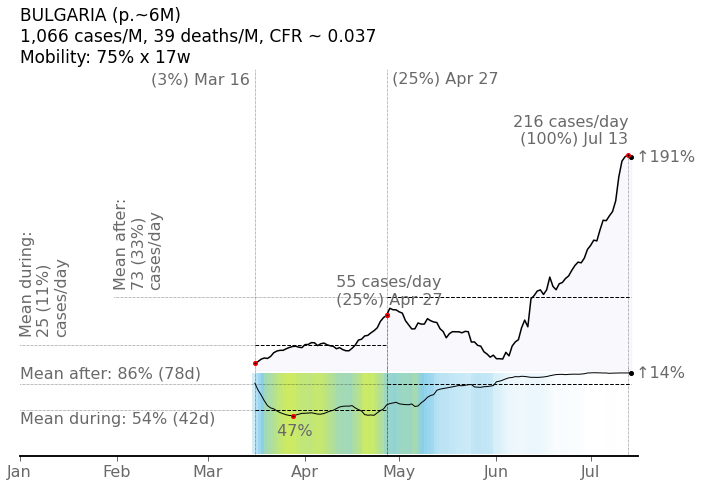

In [1235]:
fig, ax = plt.subplots(figsize=(10, 7))
fontsize = 16


plot_peak_lockdown_model(ax, df[df['state']=='Bulgaria'].set_index('date'), growth_col='new_cases_rolling_mean', fontsize=fontsize);

fig.tight_layout()
fig.savefig('../graphs/Ireland.png', format='png', dpi=200, bbox_inches = 'tight')

# US vs EU

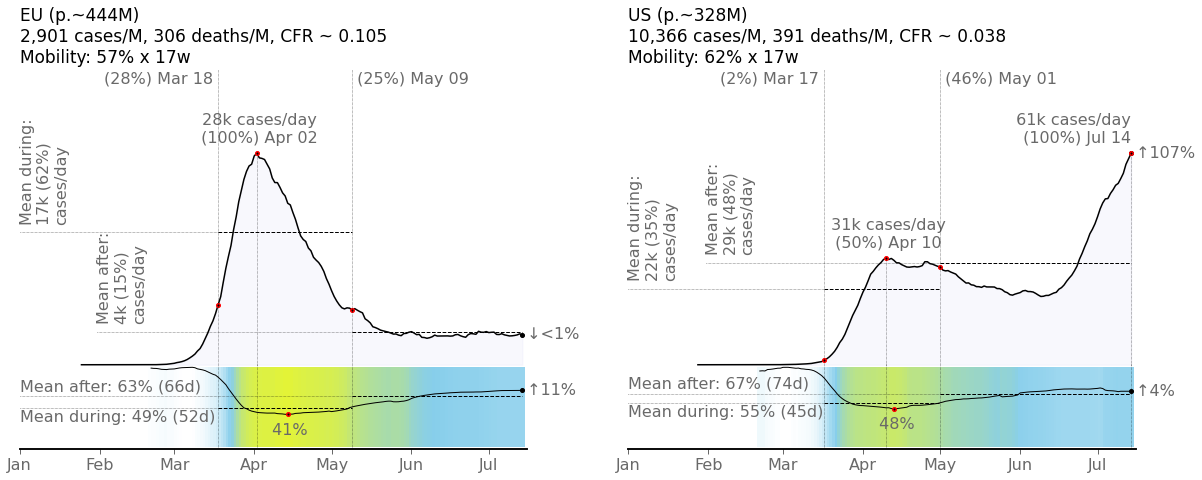

In [1223]:
fig, (ax, bx) = plt.subplots(figsize=(20, 7), ncols=2)

us_agg = df[df['aggregation']=='us'].set_index('date')
eu_agg = df[df['aggregation']=='eu'].set_index('date')

plot_peak_lockdown_model(ax, eu_agg, growth_col='new_cases_rolling_mean', fontsize=fontsize);
plot_peak_lockdown_model(bx, us_agg, growth_col='new_cases_rolling_mean', fontsize=fontsize);

fig.savefig('../graphs/eu_vs_us_cases.png', format='png', dpi=200, bbox_inches = 'tight')

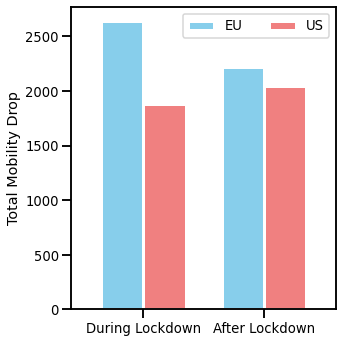

In [1224]:
sns.set_context('talk', font_scale=.8)
def get_lockdown_drop(df):

    lockdown_start = df[df['google_mobility_level_rolling_mean_stage']=='D'].index[0]
    lockdown_end = df[df['google_mobility_level_rolling_mean_stage']=='B'].index[0]

    return (100-df.loc[lockdown_start:lockdown_end]['google_mobility_level_rolling_mean']).sum()

def get_rebound_drop(df):

    rebound_start = df[df['google_mobility_level_rolling_mean_stage']=='B'].index[0]
    rebound_end = df['google_mobility_level_rolling_mean_stage'].dropna().index[-1]

    return (100-df.loc[rebound_start:rebound_end]['google_mobility_level_rolling_mean']).sum()

fig, ax = plt.subplots(figsize=(5, 5))

eu_vs_us_drops = pd.DataFrame({
    'eu': {'lockdown': get_lockdown_drop(eu_agg), 'rebound': get_rebound_drop(eu_agg)},
    'us': {'lockdown': get_lockdown_drop(us_agg), 'rebound': get_rebound_drop(us_agg)},
})

eu_vs_us_drops.plot(ax=ax, kind='bar', width=0.7, edgecolor='w', lw=3, color=['skyblue', 'lightcoral'])
ax.set_xticklabels(['During Lockdown', 'After Lockdown'], rotation=0)
ax.set_ylabel('Total Mobility Drop')

ax.legend(['EU', 'US'], ncol=2)

fig.tight_layout()

fig.savefig('../graphs/eu_vs_us_mobility_drop.png', format='png', bbox_inches = 'tight')

In [1225]:
# fig, (ax, bx) = plt.subplots(figsize=(20, 7), ncols=2)


# plot_peak_lockdown_model(ax, eu_agg, growth_col='new_deaths_rolling_mean', fontsize=fontsize);
# plot_peak_lockdown_model(bx, us_agg, growth_col='new_deaths_rolling_mean', fontsize=fontsize);

# fig.savefig('../graphs/eu_vs_us_deaths.png', format='png', dpi=200, bbox_inches = 'tight')

# US States

In [1226]:
# Focus on individual US states
us_states =  df[(df['region']=='us') & (~df['state'].isnull())]

# Get the total cases for each ... to use in sort
total_cases = us_states.groupby('state')['new_cases'].sum()

sorted_us_states = sorted(us_states[us_states['state'].notnull()].state.unique(), key=lambda c: total_cases.loc[c], reverse=True)
len(sorted_us_states)

51

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


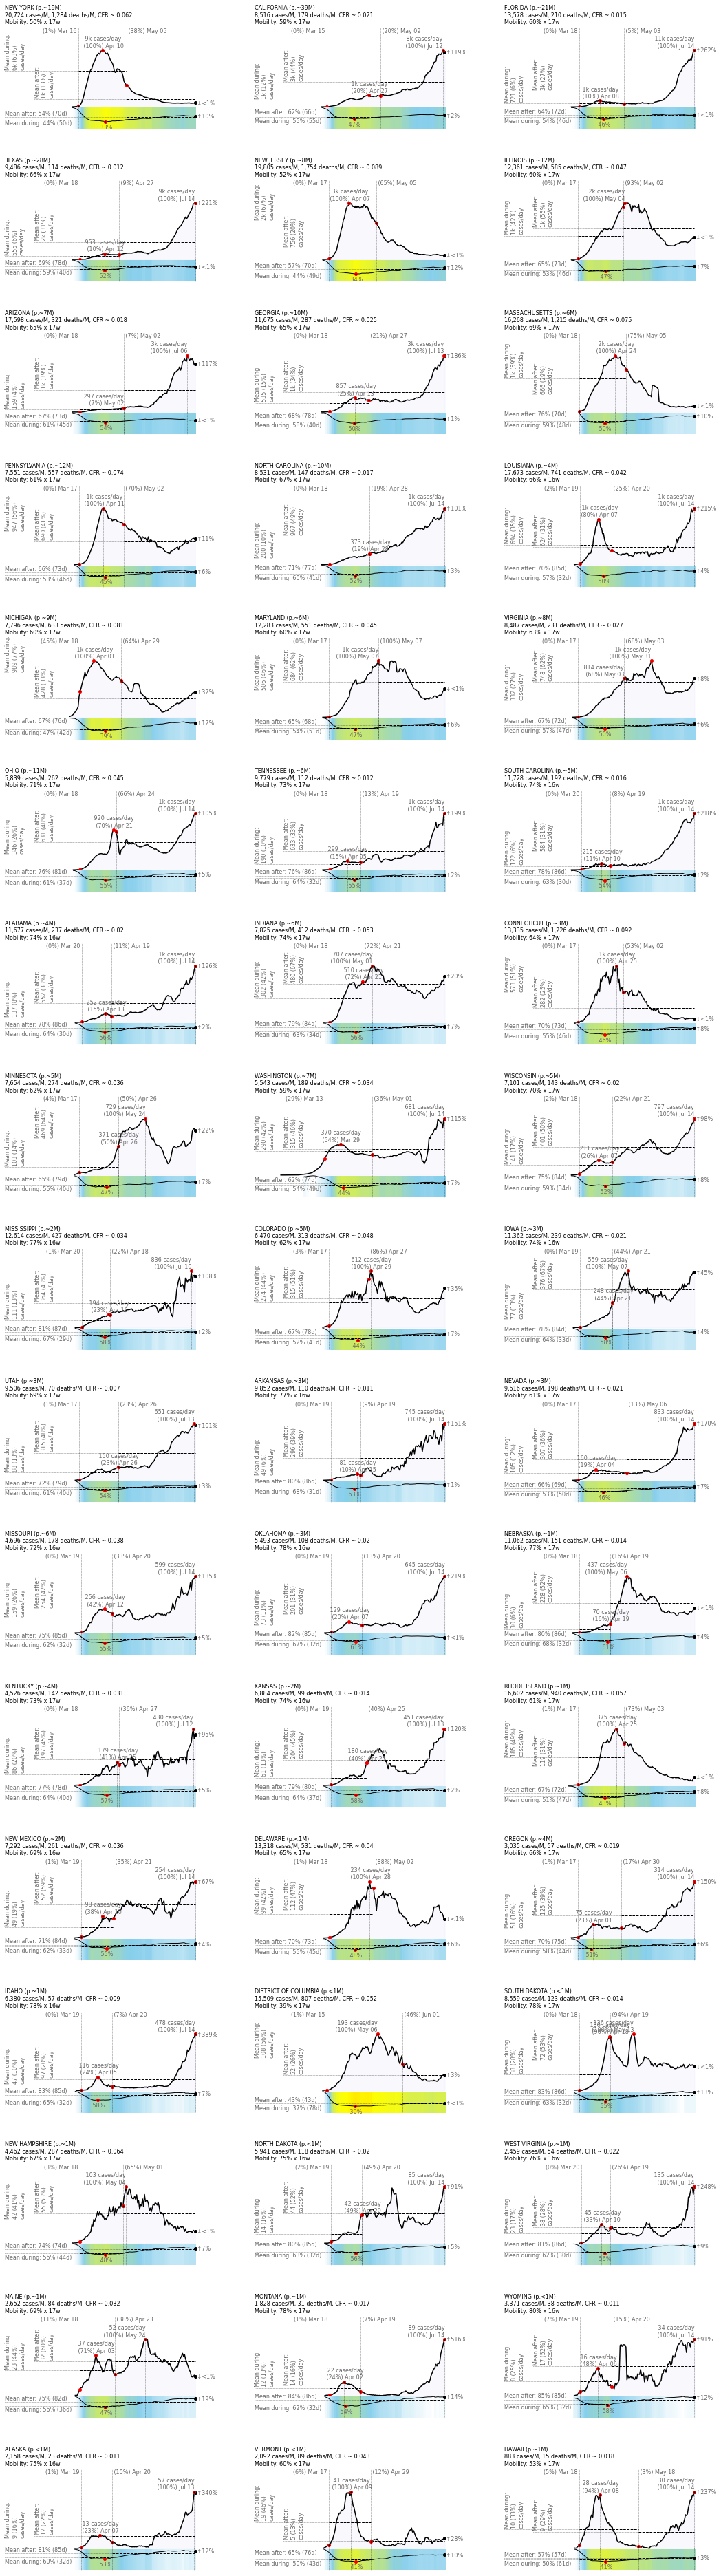

In [1227]:
w, h = 6, 4
ncols, nrows = 3, 17
fontsize = 8
hspace = 0.5
fig_format = dict(format='png', dpi=240, bbox_inches = 'tight')

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(sorted_us_states, axs.flatten()):
    
    data = us[us['state']==state].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=fontsize)

fig.tight_layout()

fig.savefig('../graphs/cases_peak_viz_for_us.png', **fig_format)

In [1228]:
# ncols, nrows = 3, 17

# fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':.3})

# for ax in axs.flatten(): ax.axis('off')

# for state, ax in zip(sorted_us_states, axs.flatten()):
    
#     data = us[us['state']==state].set_index('date')

#     plot_peak_lockdown_model(ax, data, growth_col='new_deaths_rolling_mean', peak_label='deaths/day', fontsize=fontsize)

# fig.tight_layout()

# fig.savefig('../graphs/deaths_peak_viz_for_us.png', **fig_format)

# EU Countries

In [1229]:
df.columns

Index(['aggregation', 'date', 'google_mobility_level_rolling_mean_stage',
       'new_deaths_rolling_mean_stage', 'new_cases_rolling_mean_stage',
       'country_id', 'state', 'country_code', 'continent', 'region',
       'new_cases', 'new_deaths', 'population', 'google_mobility_level',
       'google_mobility_level_by_pop', 'new_cases_rolling_mean',
       'new_deaths_rolling_mean', 'google_mobility_level_rolling_mean',
       'new_cases_rolling_mean_rel', 'new_deaths_rolling_mean_rel',
       'google_mobility_level_rolling_mean_rel',
       'new_cases_rolling_mean_stage_day', 'new_deaths_rolling_mean_stage_day',
       'google_mobility_level_rolling_mean_stage_day',
       'new_cases_rolling_mean_cummax', 'total_cases',
       'total_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'cfr', 'new_cases_rolling_mean_per_million',
       'new_deaths_rolling_mean_per_million'],
      dtype='object')

In [1231]:
# Focus on individual EU states
eu_states =  df[(df['region']=='eu') & (~df['state'].isnull())]

# Get the total cases for each ... to use in sort
total_eu_cases = eu_states.groupby('state')['new_cases'].sum()

sorted_eu_states = sorted(eu_states[eu_states['state'].notnull()].state.unique(), key=lambda c: total_eu_cases.loc[c], reverse=True)
len(sorted_eu_states)

26

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


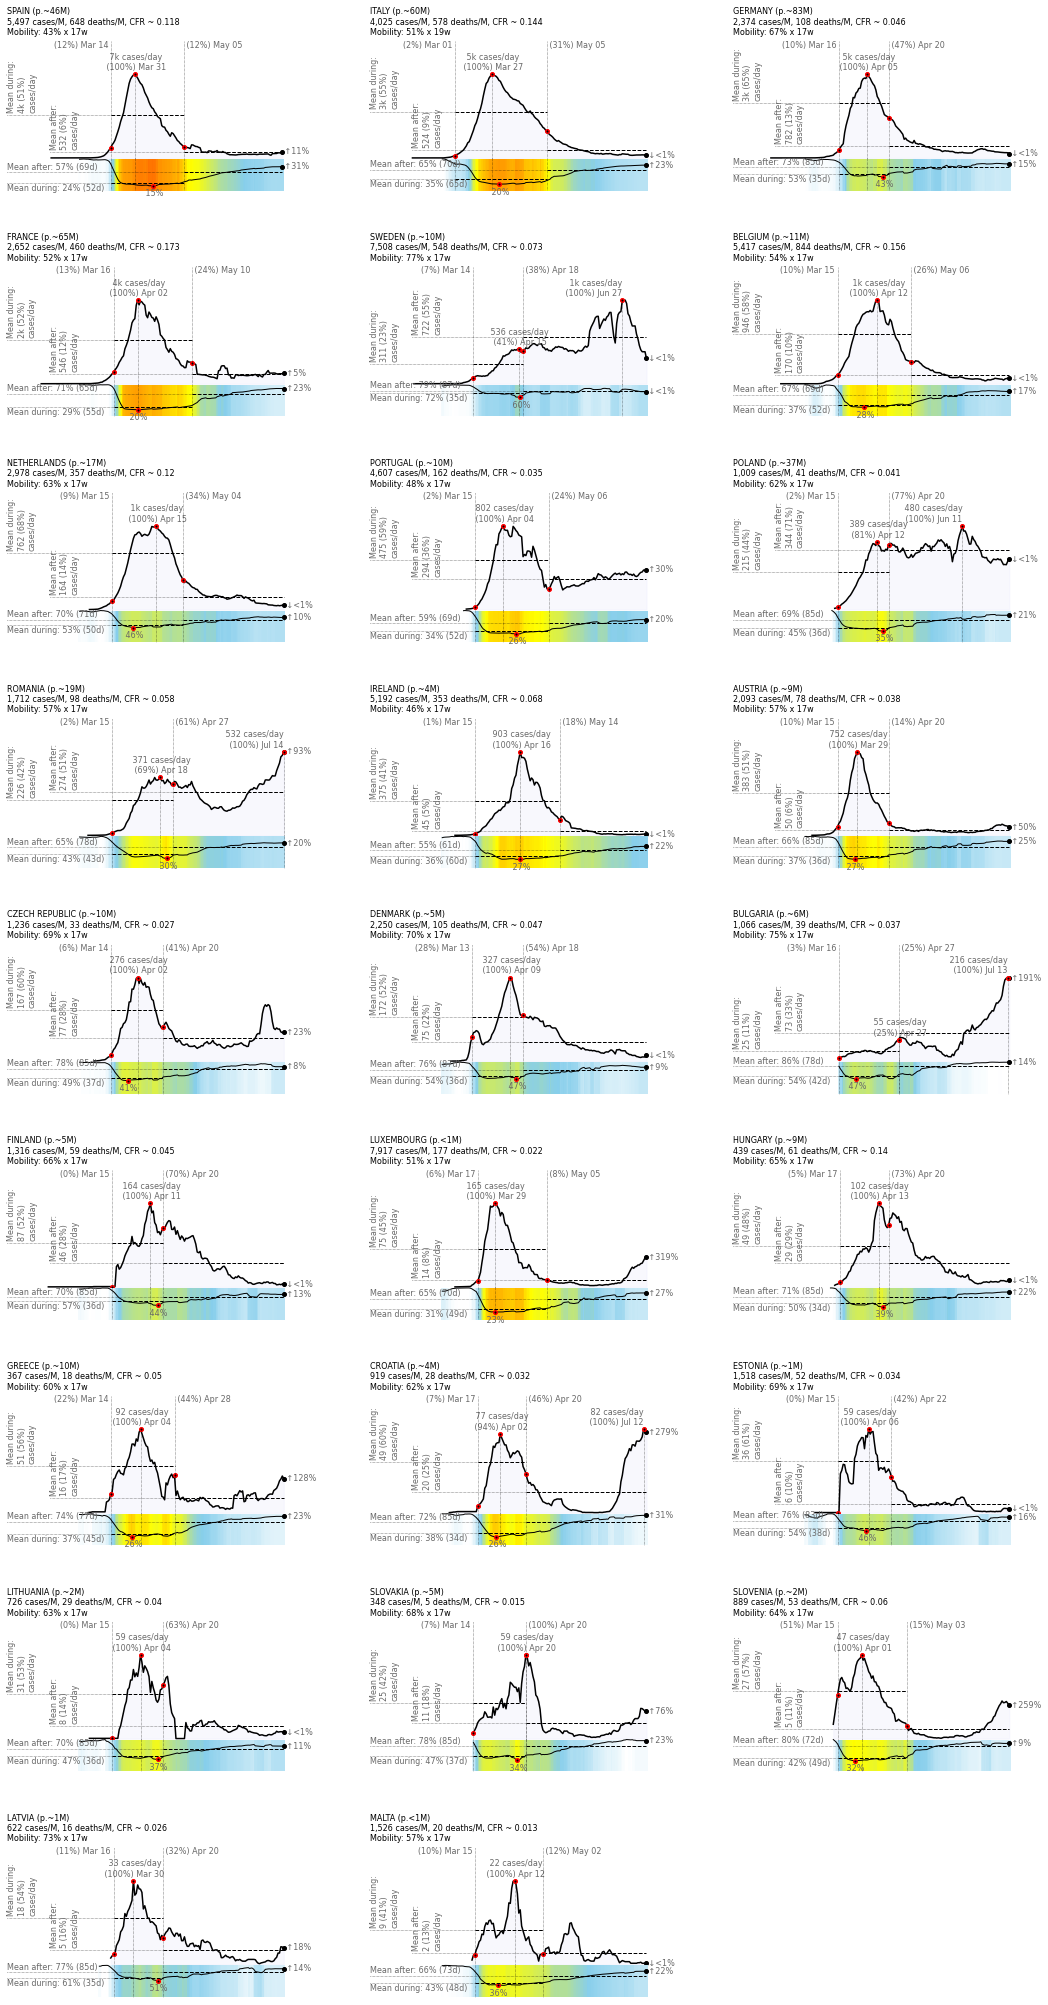

In [1232]:
ncols, nrows = 3, 9

fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':.3})

for ax in axs.flatten(): ax.axis('off')

for state, ax in zip(sorted_eu_states, axs.flatten()):
    
    data = eu[eu['aggregation']==state].set_index('date')

    plot_peak_lockdown_model(ax, data, growth_col='new_cases_rolling_mean', fontsize=fontsize)

fig.tight_layout()

fig.savefig('../graphs/cases_peak_viz_for_eu.png', **fig_format)

In [1194]:
# ncols, nrows = 3, 9

# fig, axs = plt.subplots(figsize=(ncols*w, nrows*h), nrows=nrows, ncols=ncols, gridspec_kw={'hspace': hspace, 'wspace':.3})

# for ax in axs.flatten(): ax.axis('off')

# for state, ax in zip(sorted_eu, axs.flatten()):
    
#     data = eu[eu['state']==state].set_index('date')

#     plot_peak_lockdown_model(ax, data, growth_col='new_deaths_rolling_mean', peak_label='deaths/day', fontsize=fontsize)

# fig.tight_layout()

# fig.savefig('../graphs/deaths_peak_viz_for_eu.png', **fig_format)

In [1195]:
# # Add cumulative max new case to DF
# df = df.set_index(['aggregation', 'state', 'date']).join(
#     pd.DataFrame(df.groupby(['aggregation', 'state']).apply(
#         lambda g: g.set_index('date')['new_cases_rolling_mean'].cummax())).add_suffix('_cummax')).reset_index()
# df.head()

In [1196]:
# bounce_start_date = df.groupby(['region', 'state', 'google_mobility_level_rolling_mean_stage'])['date'].first().unstack()['B']

# new_cases_at_bounce_start = df.groupby(['region', 'state', 'google_mobility_level_rolling_mean_stage'])['new_cases_rolling_mean'].first().unstack()['B']
# peak_at_bounce_start = df.groupby(['region', 'state', 'google_mobility_level_rolling_mean_stage'])['new_cases_rolling_mean_cummax'].first().unstack()['B']

# (new_cases_at_bounce_start/peak_at_bounce_start).groupby('region').mean()

In [1197]:
# ((new_cases_at_bounce_start/peak_at_bounce_start)<.5).groupby('aggregation').mean()

# Comparing States During and After Lockdown

## Combine EU & US Datasets

## Cumulative and Per Capita Cases/Deaths

In [1198]:
df['total_cases'] = df.groupby('state')['new_cases'].transform('cumsum')
df['total_cases_per_million'] = 1000000*df['total_cases']/df['population']

df['total_deaths'] = df.groupby('state')['new_deaths'].transform('cumsum')
df['total_deaths_per_million'] = 1000000*df['total_deaths']/df['population']

df['cfr'] = df['total_deaths_per_million']/df['total_cases_per_million']

df['new_cases_rolling_mean_per_million'] = 1000000*df['new_cases_rolling_mean']/df['population']
df['new_deaths_rolling_mean_per_million'] = 1000000*df['new_deaths_rolling_mean']/df['population']

## During and After Lifting Lockdown

### Mean values during and after lockdown
We need to be careful with the aggregations here because we are combining different stages of different durations.

In [1199]:
# The metrics to use during lockdown analysis
lockdown_cols = [
    'new_cases_rolling_mean', 'new_cases_rolling_mean_per_million', 
    'new_deaths_rolling_mean', 'new_deaths_rolling_mean_per_million', 
    'google_mobility_level_rolling_mean'
]

# Same, but totals per stage instead of mean-dailies.
totals_by_mobility_stage = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).apply(
    lambda g: g[lockdown_cols].sum()
).add_suffix('_by_mobility_stage_total').fillna(0)

# Durations of the stages; we need these to aggregate correctly
days_by_mobility_stage = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).size()

# Min mobility levels 
mins_by_mobility_stage = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).apply(
    lambda g: g[lockdown_cols].min()
).add_suffix('_by_mobility_stage_min').fillna(0)


# The number of days until and after the hold peak.
date_of_hold_peak = df[df['google_mobility_level_rolling_mean_stage'].isin(['H'])].groupby(['aggregation', 'state']).apply(
    lambda g: g.set_index('date')['new_cases_rolling_mean_per_million'].idxmax())

date_of_hold_start = df[df['google_mobility_level_rolling_mean_stage']=='H'].groupby(['aggregation', 'state']).first()['date']
date_of_bounce_start = df[df['google_mobility_level_rolling_mean_stage']=='B'].groupby(['aggregation', 'state']).first()['date']

days_to_hold_peak = (date_of_hold_peak-date_of_hold_start).map(lambda d: d.days)
days_from_hold_peak = (date_of_bounce_start-date_of_hold_peak).map(lambda d: d.days)






# Generate an overall mean for the stages
def calculate_means_for_stages(totals_by_stage, days_by_stage, stage_cols, metric_col):
    return totals_by_stage.unstack()[metric_col][stage_cols].sum(axis=1)/days_by_stage.unstack()[stage_cols].sum(axis=1)

# Focus on Drop and Hold as the key during-lockdown stages and calculate the mean cases/deaths per million per day
during_lockdown_stages = ['D', 'H']

mean_new_cases_per_million_during = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, during_lockdown_stages, 'new_cases_rolling_mean_per_million_by_mobility_stage_total')

mean_new_deaths_per_million_during = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, during_lockdown_stages, 'new_deaths_rolling_mean_per_million_by_mobility_stage_total')

mean_mobility_levels_during = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, during_lockdown_stages, 'google_mobility_level_rolling_mean_by_mobility_stage_total')


# Focus on Bounce and Normal as the key after-lockdown stages and calculate the mean cases/deaths per million per day
after_lockdown_stages = ['B', 'N']

mean_new_cases_per_million_after = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, after_lockdown_stages, 'new_cases_rolling_mean_per_million_by_mobility_stage_total')

mean_new_deaths_per_million_after = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, after_lockdown_stages, 'new_deaths_rolling_mean_per_million_by_mobility_stage_total')

mean_mobility_levels_after = calculate_means_for_stages(
    totals_by_mobility_stage, days_by_mobility_stage, after_lockdown_stages, 'google_mobility_level_rolling_mean_by_mobility_stage_total')


# The relative new cases at the end of the hold/start of the bounce.
new_cases_at_start_of_bounce = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).first()['new_cases_rolling_mean'].unstack()['B']
current_peak_at_start_of_bounce = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).first()['new_cases_rolling_mean_cummax'].unstack()['B']

rel_cases_at_start_of_bounce = new_cases_at_start_of_bounce/current_peak_at_start_of_bounce

# The new cases at the start of the drop as a fraction of the lockdown peak.
new_cases_at_start_of_drop = df.groupby(['aggregation', 'state', 'google_mobility_level_rolling_mean_stage']).first()['new_cases_rolling_mean'].unstack()['D']
rel_cases_at_start_of_drop = new_cases_at_start_of_drop/current_peak_at_start_of_bounce



## Comparing During and After Lockdown by EU and US State

### Setup States

In [1200]:
use_states = [*eu_states['state'].unique(), *us_states['state'].unique()]
len(use_states)

78

In [1201]:
# Sort in ascending order of the relative change in mean new case per day during vs after lockdown.
sorted_states = (mean_new_cases_per_million_after/mean_new_cases_per_million_during).sort_values(ascending=True).loc[use_states]
sorted_states.shape

(77,)

In [1202]:
regions = df.groupby(['aggregation', 'state']).first()['region']
regions

aggregation  state      
Afghanistan  Afghanistan      south_asia
Alabama      Alabama                  us
Alaska       Alaska                   us
Albania      Albania              non-eu
Algeria      Algeria        north_africa
                                ...     
Wisconsin    Wisconsin                us
Wyoming      Wyoming                  us
Yemen        Yemen           middle_east
Zambia       Zambia          east_africa
Zimbabwe     Zimbabwe        east_africa
Name: region, Length: 258, dtype: object

In [1203]:
# The main dataframe
data = pd.DataFrame({
    
    # The main bars will use the average daily new cases/deaths during and after lockdown
    'mean_new_cases_per_million_during': mean_new_cases_per_million_during,
    'mean_new_deaths_per_million_during': mean_new_deaths_per_million_during,

    'mean_new_cases_per_million_after': mean_new_cases_per_million_after,
    'mean_new_deaths_per_million_after': mean_new_deaths_per_million_after,
    
    'mean_mobility_levels_during': mean_mobility_levels_during,
    'mean_mobility_levels_after': mean_mobility_levels_after,
    
    'rel_mean_mobility_levels_during': mean_mobility_levels_during/mean_mobility_levels_during.max(),
    'rel_mean_mobility_levels_after': mean_mobility_levels_after/mean_mobility_levels_after.max(),
    
    'total_mobility_levels_during': totals_by_mobility_stage.unstack()['google_mobility_level_rolling_mean_by_mobility_stage_total']['H'],
    'min_mobility_levels_during': mins_by_mobility_stage.unstack()['google_mobility_level_rolling_mean_by_mobility_stage_min']['H'],

    # Days to/from hold peak
    'num_hold_days': days_by_mobility_stage.unstack()['H'],
    'days_to_hold_peak': days_to_hold_peak,
    'days_from_hold_peak': days_from_hold_peak,
    
    # The relative differences during vs after
    'rel_cases_during_after': (mean_new_cases_per_million_after/mean_new_cases_per_million_during)-1,
    'rel_deaths_during_after': (mean_new_deaths_per_million_after/mean_new_deaths_per_million_during)-1,
    'rel_mobility_during_after': (mean_mobility_levels_after/mean_mobility_levels_during)-1,
    
    'rel_cases_at_start_of_bounce': rel_cases_at_start_of_bounce,
    'rel_cases_at_start_of_drop': rel_cases_at_start_of_drop,
    
    'region': regions,

}).dropna()

data.shape

(170, 19)

In [1234]:
use_data.loc['Alaska']

,mean_new_cases_per_million_during,mean_new_deaths_per_million_during,mean_new_cases_per_million_after,mean_new_deaths_per_million_after,mean_mobility_levels_during,mean_mobility_levels_after,rel_mean_mobility_levels_during,rel_mean_mobility_levels_after,total_mobility_levels_during,min_mobility_levels_during,num_hold_days,days_to_hold_peak,days_from_hold_peak,rel_cases_during_after,rel_deaths_during_after,rel_mobility_during_after,rel_cases_at_start_of_bounce,rel_cases_at_start_of_drop,region
state,,,,,,,,,,,,,,,,,,,
Alaska,12.717702,0.378358,14.991421,0.1286,62.81994,84.199768,0.690126,0.816006,1320.095238,55.714286,23.0,10.0,13.0,0.178784,-0.66011,0.340335,0.468085,0.06383,us


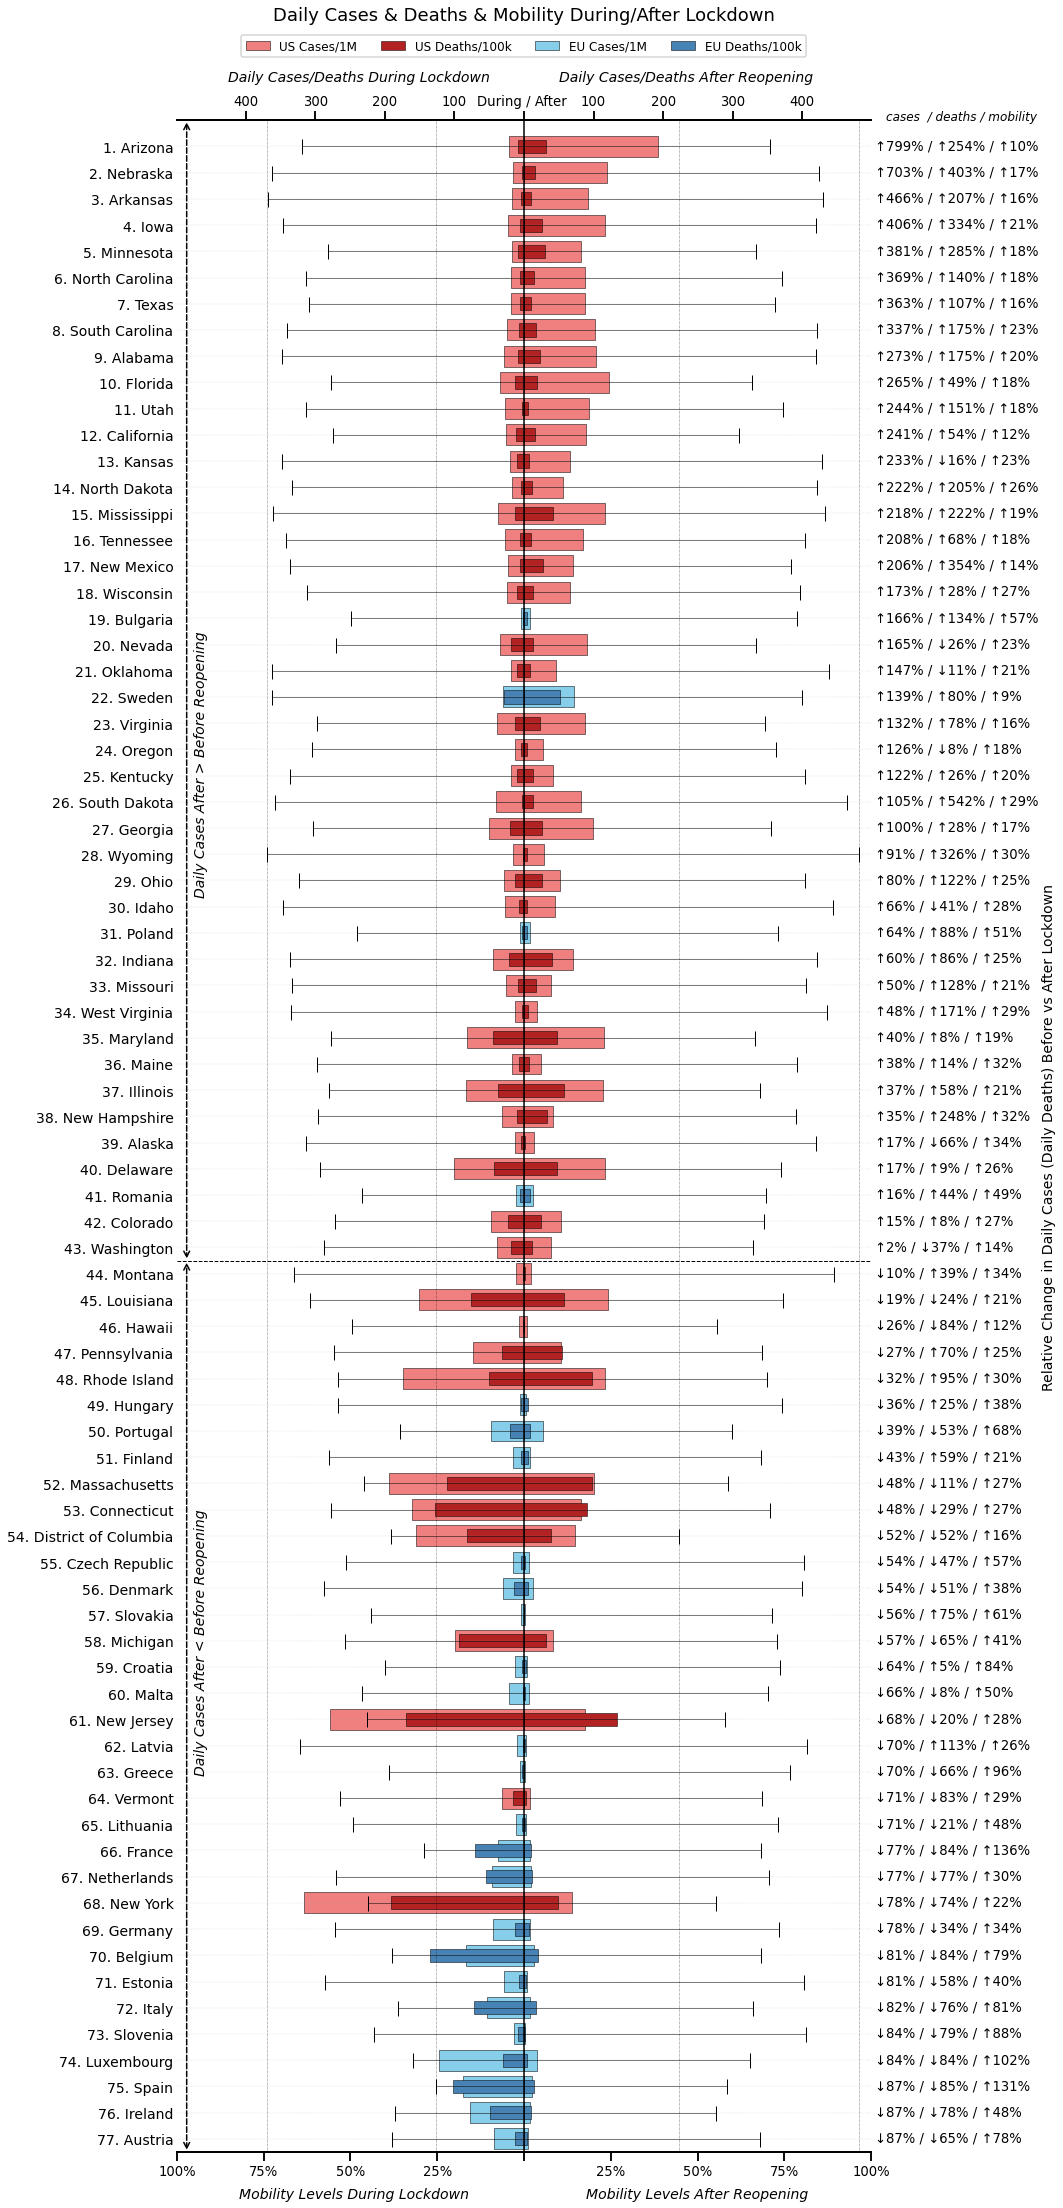

In [1204]:
bar_height = .4

use_data = data.loc[sorted_states.index]  # Select and sort the states we want (EU and US)

fig, ax = plt.subplots(figsize=(15, len(sorted_states)*bar_height))

# --- THE DAILY CASES/DEATHS BARS (ax)

# Colours for the US and EU barsl; a sequence of colours that match the sorting
bar_colours1 = np.where(sorted_states.reset_index()['aggregation'].isin(us_states['state'].unique()), 'lightcoral', 'skyblue')
bar_colours2 = np.where(sorted_states.reset_index()['aggregation'].isin(us_states['state'].unique()), 'firebrick', 'steelblue')

# Plot the daily case bars using the mean new cases/M during & after.
w1 = .8
((-use_data['mean_new_cases_per_million_during'])-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)
(use_data['mean_new_cases_per_million_after']-w1/2).plot(kind='barh', ax=ax, width=w1, color=bar_colours1, edgecolor='k', linewidth=.5)

# Plot the daily death bars using the mean new deaths/M during & after; multiple by 10 to display as deaths/100k
w2=.5
(((-use_data['mean_new_deaths_per_million_during']*10)-w2/2)).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)
((use_data['mean_new_deaths_per_million_after']*10-w2/2)).plot(kind='barh', ax=ax, width=w2, color=bar_colours2, edgecolor='k', linewidth=.5)



# --- THE MOBILITY LEVELS (bx)
bx = ax.twiny()

# Plot the mobility indicators.
bx.plot(-use_data['mean_mobility_levels_during'], range(len(use_data['mean_mobility_levels_during'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')
bx.plot(use_data['mean_mobility_levels_after'], range(len(use_data['mean_mobility_levels_after'])), lw=0, marker='|', markersize=15, markerfacecolor='none', c='k')

# Connect the indicators
for y, (during, after) in enumerate(zip(use_data['mean_mobility_levels_during'].values, use_data['mean_mobility_levels_after'].values)):
    bx.plot([-during, after], [y]*2, c='k', lw=.5)
    
# Mark the min/max relative mobility during/after for reference
bx.axvline(-use_data['mean_mobility_levels_during'].min(), lw=0.5, ls=':', c='k')
bx.axvline(-use_data['mean_mobility_levels_during'].max(), lw=0.5, ls=':', c='k')

bx.axvline(use_data['mean_mobility_levels_after'].min(), lw=0.5, ls=':', c='k')
bx.axvline(use_data['mean_mobility_levels_after'].max(), lw=0.5, ls=':', c='k')


    
# --- RELATIVE CHANGE INDICATORS (cx)
cx = ax.twinx()

# Add labels to indicate relative change in cases before/after lockdown.
cx_labels = []

def gen_rel_label(v):
    if (v != np.nan) & (v != np.inf):
        if v>0: return '↑{}%'.format(int(abs(v)))
        elif v<0: return '↓{}%'.format(int(abs(v)))
    return '↔0%'

for y, (_, (rel_cases, rel_deaths, rel_mobility)) in enumerate(use_data[['rel_cases_during_after', 'rel_deaths_during_after', 'rel_mobility_during_after']].iterrows()):
    
    cx_label = '{} / {} / {}'.format(gen_rel_label(rel_cases*100), gen_rel_label(rel_deaths*100), gen_rel_label(rel_mobility*100))
    cx_labels.append(cx_label)



# --- CONFIGURE THE AXES

# The daily cases/deaths axis
ax.xaxis.tick_top()

ax.set_xlim(-499, 499)
ax.set_xticks(np.arange(-400, 451, 100))
ax.set_xticklabels(['400', '300', '200', '100', 'During / After ', '100', '200', '300', '400'])
ax.set_ylim(-.5, len(sorted_states))

# Plot the vertical centre line separating the before and after data.
ax.axvline(0, lw=1.5, c='k')

# Add the state labels with a ranking number
state_labels = ['{}. {}'.format((len(sorted_states)-rank), state) for rank, state in enumerate(sorted_states.reset_index()['state'])]
ax.set_yticklabels(state_labels, fontsize=14)
ax.set_ylabel('')

# Add annotations to separate growers vs decliners
crossing = use_data['rel_cases_during_after'].index.get_loc(use_data['rel_cases_during_after'][use_data['rel_cases_during_after']>0].index[0])-0.5
ax.axhline(crossing, lw=1, c='k', ls='--')
ax.axhline(-.5, lw=1.5, c='k')

ax.annotate(s='', xy=(-485, crossing), xytext=(-485, ax.get_ylim()[1]), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, crossing+14, 'Daily Cases After > Before Reopening', rotation=90, fontsize=14, style='italic')

ax.annotate(s='', xy=(-485,crossing), xytext=(-485, -.5), arrowprops=dict(arrowstyle='<->', linestyle="dashed"))
ax.text(-475, 14, 'Daily Cases After < Before Reopening', rotation=90, fontsize=14, style='italic')

# Add the main titles for the bar charts
ax.set_title('Daily Cases & Deaths & Mobility During/After Lockdown', pad=100, fontsize=18)
ax.text(-425, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths During Lockdown', style='italic', fontsize=14)
ax.text(50, ax.get_ylim()[1]+1.5, 'Daily Cases/Deaths After Reopening', style='italic', fontsize=14)


# The mobility axis
bx.xaxis.tick_bottom()

bx.set_xlim(-100, 100)
bx.set_xticks(np.arange(-100, 101, 25))
bx.set_xticklabels(['100%', '75%', '50%', '25%', '', '25%', '50%', '75%', '100%'])

# Labels
bx.text(-82, ax.get_ylim()[0]-1.75, 'Mobility Levels During Lockdown', style='italic', fontsize=14)
bx.text(82, ax.get_ylim()[0]-1.75, 'Mobility Levels After Reopening', style='italic', fontsize=14, ha='right')


# The relative change axis (righ-hand y-axis)
cx.set_ylim(*ax.get_ylim())
cx.set_yticks(np.arange(.1, len(cx_labels), 1))

cx.set_yticklabels(cx_labels)
cx.set_ylabel('Relative Change in Daily Cases (Daily Deaths) Before vs After Lockdown', fontsize=14)
cx.text(520, ax.get_ylim()[1], 'cases  / deaths / mobility', style='italic', fontsize=12)



# Build the Legend
legend_elements = [
    Patch(facecolor='lightcoral', edgecolor='k',lw=.5, label='US Cases/1M'),
    Patch(facecolor='firebrick', edgecolor='k',lw=.5, label='US Deaths/100k'),
    Patch(facecolor='skyblue', edgecolor='k',lw=.5, label='EU Cases/1M'),
    Patch(facecolor='steelblue', edgecolor='k',lw=.5, label='EU Deaths/100k')
]

ax.legend(handles=legend_elements, ncol=4, loc='best', bbox_to_anchor=(.915, 1.045), frameon=True, fontsize=12)

    
    
# Remove the frame and the ytick marks
for xx in [ax, bx, cx]:
    xx.spines['right'].set_visible(False)
    xx.spines['left'].set_visible(False)
    xx.tick_params(axis = 'y', which = 'major', width=0, length=0)

# Add gridlines
ax.grid(True, axis='y', ls=':', lw=.33)

fig.tight_layout()

fig.savefig('../graphs/before_vs_after_lockdown.png', **fig_format)

# What Makes for a Good Lockdown
Next we consider what success looks like post lockdown. In other words what do we minimally want to achieve as a result of a lockdown? Then we consider the inredients of a lockdown that appear to impact on whether a lockdown will be successful.

## The Exit Ratio
The exit ratio of a lockdown is the ratio of current new cases per day to peak new cases per day at the end of the lockdown; the peak value is the peak of new cases seen so far, which may be less than the overall peak if it occurs in the future.

In [1205]:
data['exit_ratio'] = data['rel_cases_at_start_of_bounce']
data.loc[sorted_states.index].groupby('region')['exit_ratio'].mean()

region
eu    0.470412
us    0.752731
Name: exit_ratio, dtype: float64

## The Rebound Ratio
The rebound ratio is the ratio of new cases/day after the lockdown vs during the lockdown. 

In [707]:
data['rebound_ratio'] = data['mean_new_cases_per_million_after']/data['mean_new_cases_per_million_during']
data['is_pos_rebound'] = data['rebound_ratio']>1

data.loc[sorted_states.index].groupby('region')['rebound_ratio'].median()

region
eu    0.296374
us    1.913517
Name: rebound_ratio, dtype: float64

## Strong Lockdowns & Conservative Rebounds

In [708]:
data['is_strong_lockdown'] = data['mean_mobility_levels_during']<50
data['is_conservative_rebound'] = data['mean_mobility_levels_after']<70

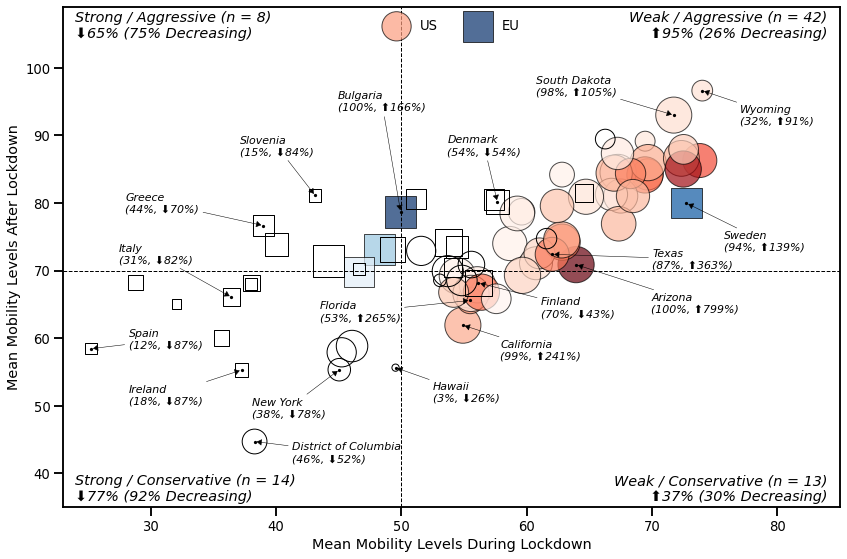

In [709]:
fig, ax = plt.subplots(figsize=(12, 8))

us_state_names = list(us['state'].unique())
eu_state_names = list(eu['state'].unique())
# The US and EU data
us_data = data.loc[us_state_names]
eu_data = data.loc[eu_state_names]

us_pos_rebounds = us_data['is_pos_rebound']
eu_pos_rebounds = eu_data['is_pos_rebound']


# Colour maps for the US and EU
us_cmap = plt.cm.Reds
us_norm = matplotlib.colors.Normalize(vmin=1)
us_sm = plt.cm.ScalarMappable(cmap=us_cmap, norm=us_norm)

eu_cmap = plt.cm.Blues
eu_norm = matplotlib.colors.Normalize(vmin=1)
eu_sm = plt.cm.ScalarMappable(cmap=eu_cmap, norm=eu_norm)

us_colours = us_cmap(us_norm(us_data[us_pos_rebounds]['rebound_ratio']))
eu_colours = eu_cmap(eu_norm(eu_data[eu_pos_rebounds]['rebound_ratio']))


# --- THE MAIN SCATTER PLOTS
size_scale = 1.5

# The increasing rebounds
ax.scatter(us_data[us_pos_rebounds]['mean_mobility_levels_during'], us_data[us_pos_rebounds]['mean_mobility_levels_after'], 
           s=us_data[us_pos_rebounds]['exit_ratio']*120**size_scale, 
           marker='o', edgecolor='k', lw=1, label='US', color=us_colours, alpha=.7)

ax.scatter(eu_data[eu_pos_rebounds]['mean_mobility_levels_during'], eu_data[eu_pos_rebounds]['mean_mobility_levels_after'], 
           s=eu_data[eu_pos_rebounds]['exit_ratio']*100**size_scale, 
           marker='s', edgecolor='k', lw=1, label='EU', color=eu_colours, alpha=.7)

# The decreasing rebounds
ax.scatter(us_data[~us_pos_rebounds]['mean_mobility_levels_during'], us_data[~us_pos_rebounds]['mean_mobility_levels_after'], 
           s=us_data[~us_pos_rebounds]['exit_ratio']*120**size_scale, 
           marker='o', edgecolor='k', lw=1, color='none')

ax.scatter(eu_data[~eu_pos_rebounds]['mean_mobility_levels_during'], eu_data[~eu_pos_rebounds]['mean_mobility_levels_after'], 
           s=eu_data[~eu_pos_rebounds]['exit_ratio']*100**size_scale, 
           marker='s', edgecolor='k', lw=1, color='none')


# --- ANNOTATIONS

# The rebound ratios converted to % increase/decrease
rebound_ratios_by_quadrant = ((data.loc[sorted_states.index].groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio'].median()-1)*100)

frac_pos_rebounds_by_quadrant = data.loc[sorted_states.index].groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_pos_rebound'].mean()

n_by_quadrant = data.loc[sorted_states.index].groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['is_pos_rebound'].size()

# A label helper
def add_arrow(n): 
    label = '⬆{}'.format(int(n)) if n>0 else '⬇️{}'.format(int(abs(n)))
    return label

strong_aggressive_label = 'Strong / Aggressive (n = {})\n{}% ({}% Decreasing)'.format(
    n_by_quadrant.loc[True].loc[False],
    add_arrow(rebound_ratios_by_quadrant.loc[True].loc[False]), 
    int(100*(1-frac_pos_rebounds_by_quadrant.loc[True].loc[False]))
)

strong_conservative_label = 'Strong / Conservative (n = {})\n{}% ({}% Decreasing)'.format(
    n_by_quadrant.loc[True].loc[True],
    add_arrow(rebound_ratios_by_quadrant.loc[True].loc[True]), 
    int(100*(1-frac_pos_rebounds_by_quadrant.loc[True].loc[True]))
)

weak_aggressive_label = 'Weak / Aggressive (n = {})\n{}% ({}% Decreasing)'.format(
    n_by_quadrant.loc[False].loc[False],
    add_arrow(rebound_ratios_by_quadrant.loc[False].loc[False]), 
    int(100*(1-frac_pos_rebounds_by_quadrant.loc[False].loc[False]))
)

weak_conservative_label = 'Weak / Conservative (n = {})\n{}% ({}% Decreasing)'.format(
    n_by_quadrant.loc[False].loc[True],
    add_arrow(rebound_ratios_by_quadrant.loc[False].loc[True]), 
    int(100*(1-frac_pos_rebounds_by_quadrant.loc[False].loc[True]))
)


# Need to set the axis limits before plotting the labels
ax.set_xlim(23, 85)
ax.set_ylim(35, 109)

ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[1]-.5, strong_aggressive_label, style='italic', ha='left', va='top')
ax.text(ax.get_xlim()[0]+1, ax.get_ylim()[0]+.5, strong_conservative_label, style='italic', ha='left', va='bottom')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[1]-.5, weak_aggressive_label, style='italic', ha='right', va='top')
ax.text(ax.get_xlim()[1]-1, ax.get_ylim()[0]+.5, weak_conservative_label, style='italic', ha='right', va='bottom')

# Highlight specific states
highlights = [
    ('District of Columbia', 0, -3), 
    ('New York', -10, -7),
    ('Arizona', 3, -7),
    ('Texas', 5, -2),
    ('California', 0, -5),
    ('Hawaii', 0, -5),
    ('Wyoming', 0, -5),
    ('South Dakota', -14, 3),
    ('Florida', -15, -3),
    
    ('Ireland', -12, -5),
    ('Spain', 0, 0),
    ('Italy', -12, 5),
    ('Sweden', 0, -7),
    ('Denmark', -7, 7),

    ('Finland', 2, -5),
    ('Slovenia', -9, 6),
    ('Bulgaria', -8, 15),
    ('Greece', -14, 2),
]

for highlight, x_offset, y_offset in highlights:
    state = data.loc[highlight]
    x, y = state['mean_mobility_levels_during'], state['mean_mobility_levels_after']
    label = '{}\n({}%, {}%)'.format(
        highlight, 
        int(100*data.loc[highlight]['exit_ratio'].values[0]), 
        add_arrow(int(100*(data.loc[highlight]['rebound_ratio'].values[0]-1)))
    )
    
    ax.annotate(
        label, xy=(x, y), xytext=(x+3+x_offset, y+y_offset), 
        arrowprops=dict(facecolor='k', arrowstyle='-|>, head_width=.25', lw=.5), fontsize=11, style='italic',
    )
    
    ax.scatter([x], [y], s=3, marker='o', color='k')


# The separating lines
ax.axvline(50, lw=1, ls='--', c='k')
ax.axhline(70, lw=1, ls='--', c='k')

ax.set_xlabel('Mean Mobility Levels During Lockdown')
ax.set_ylabel('Mean Mobility Levels After Lockdown')

ax.legend(ncol=2, frameon=False, loc='upper center')

fig.tight_layout()



In [710]:
data

,,mean_new_cases_per_million_during,mean_new_deaths_per_million_during,mean_new_cases_per_million_after,mean_new_deaths_per_million_after,mean_mobility_levels_during,mean_mobility_levels_after,rel_mean_mobility_levels_during,rel_mean_mobility_levels_after,total_mobility_levels_during,min_mobility_levels_during,...,rel_deaths_during_after,rel_mobility_during_after,rel_cases_at_start_of_bounce,rel_cases_at_start_of_drop,region,exit_ratio,rebound_ratio,is_pos_rebound,is_strong_lockdown,is_conservative_rebound
aggregation,state,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Afghanistan,1.809617,0.053175,7.381899,0.242203,63.823529,70.386243,0.701151,0.682135,2028.952381,55.333333,...,3.554804,0.102826,1.000000,0.007808,south_asia,1.000000,4.079261,True,False,False
Alabama,Alabama,27.757468,0.821623,103.674928,2.259938,69.641270,84.229489,0.765063,0.816294,894.238095,61.000000,...,1.750577,0.209477,0.742922,0.045300,us,0.742922,3.735028,True,False,False
Alaska,Alaska,12.717702,0.378358,14.991421,0.128600,62.819940,84.199768,0.690126,0.816006,1320.095238,55.714286,...,-0.660110,0.340335,0.468085,0.063830,us,0.468085,1.178784,True,False,False
Angola,Angola,0.022141,0.001902,0.138854,0.007324,49.020833,72.715590,0.538532,0.704709,1265.238095,45.333333,...,2.851272,0.483361,0.272727,0.363636,central_africa,0.272727,6.271451,True,True,False
Antigua and Barbuda,Antigua and Barbuda,8.023387,0.833599,6.056780,0.092329,37.127551,55.815552,0.407875,0.540926,404.476190,18.904762,...,-0.889241,0.503346,0.100000,0.300000,carribean,0.100000,0.754891,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wisconsin,Wisconsin,24.161832,1.000910,66.017531,1.289484,62.420168,79.563786,0.685734,0.771077,1515.523810,55.523810,...,0.288312,0.274649,0.853955,0.079784,us,0.853955,2.732307,True,False,False
Wyoming,Wyoming,15.488806,0.092563,29.638088,0.394332,74.004464,96.619048,0.812997,0.936365,978.285714,66.571429,...,3.260163,0.305584,0.327586,0.146552,us,0.327586,1.913517,True,False,False
Yemen,Yemen,0.432136,0.130386,0.868899,0.244151,80.624339,92.791209,0.885721,0.899268,294.380952,72.190476,...,0.872527,0.150908,1.000000,0.752137,middle_east,1.000000,2.010705,True,False,False


In [711]:
europe_state_names = df[df['continent']=='Europe']['state'].dropna().unique()
asia_state_names = df[df['continent']=='Asia']['state'].dropna().unique()

In [712]:
strong = data['is_strong_lockdown']
conservative = data['is_conservative_rebound']

all_strong = data[strong].loc[[*us_state_names, *europe_state_names]]
all_weak = data[~strong].loc[[*us_state_names, *europe_state_names]]

all_conservative = data[conservative].loc[[*us_state_names, *europe_state_names]]
all_aggressive = data[~conservative].loc[[*us_state_names, *europe_state_names]]

ttest_ind(all_strong['rebound_ratio'], all_weak['rebound_ratio']), ttest_ind(all_conservative['rebound_ratio'], all_aggressive['rebound_ratio']),

(Ttest_indResult(statistic=-3.522667745716009, pvalue=0.0006865788747022395),
 Ttest_indResult(statistic=-2.364453657362835, pvalue=0.020308247068914074))

In [713]:


strong_and_conservative = data[strong & conservative].loc[[*us_state_names, *europe_state_names]]
weak_and_conservative = data[~strong & conservative].loc[[*us_state_names, *europe_state_names]]

strong_and_aggressive = data[strong & ~conservative].loc[[*us_state_names, *europe_state_names]]
weak_and_aggressive = data[~strong & ~conservative].loc[[*us_state_names, *europe_state_names]]



[
    ttest_ind(strong_and_conservative['rebound_ratio'], weak_and_conservative['rebound_ratio']),
    ttest_ind(strong_and_conservative['rebound_ratio'], strong_and_aggressive['rebound_ratio']),
    ttest_ind(strong_and_conservative['rebound_ratio'], weak_and_aggressive['rebound_ratio']),
    
    ttest_ind(weak_and_conservative['rebound_ratio'], weak_and_aggressive['rebound_ratio']),
    ttest_ind(weak_and_conservative['rebound_ratio'], strong_and_aggressive['rebound_ratio']),

    ttest_ind(strong_and_aggressive['rebound_ratio'], weak_and_aggressive['rebound_ratio']),
    
]

[Ttest_indResult(statistic=-3.4968104595997005, pvalue=0.0015896009404891523),
 Ttest_indResult(statistic=-1.430813760755778, pvalue=0.16439364233622172),
 Ttest_indResult(statistic=-3.048093392236218, pvalue=0.003382772134139583),
 Ttest_indResult(statistic=-0.9326314924118909, pvalue=0.3548765320060806),
 Ttest_indResult(statistic=1.7251787355338453, pvalue=0.0985173843472352),
 Ttest_indResult(statistic=-1.9119372138097324, pvalue=0.06100548959333612)]

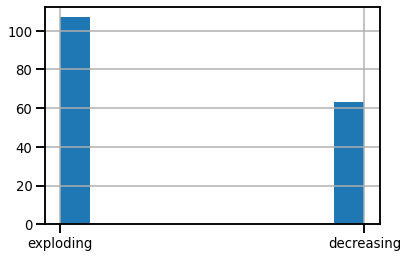

In [714]:

def get_rebound_scale(r):
    
    if r<1:
        return 'decreasing'
#     elif (r<2):
#         return 'increasing'
    else:
        return 'exploding'
    
data['rebound_ratio_scale'] = data['rebound_ratio'].map(get_rebound_scale)
data['rebound_ratio_scale'].hist()

In [719]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

d = data.loc[[*us_state_names, *eu_state_names]]

scoring = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy', ]
X = d[['days_to_hold_peak', 'days_from_hold_peak', 'mean_mobility_levels_during', 'exit_ratio', 'rel_cases_at_start_of_drop']]
y = d['is_pos_rebound']

scaled_X = preprocessing.scale(X)

clf = KNeighborsClassifier(n_neighbors=1)
clf = GradientBoostingClassifier()

scores = cross_validate(clf, scaled_X, y, scoring=scoring, cv=10)
scores['test_roc_auc'].mean()

0.9525

In [699]:
d

,,mean_new_cases_per_million_during,mean_new_deaths_per_million_during,mean_new_cases_per_million_after,mean_new_deaths_per_million_after,mean_mobility_levels_during,mean_mobility_levels_after,rel_mean_mobility_levels_during,rel_mean_mobility_levels_after,total_mobility_levels_during,min_mobility_levels_during,...,rel_mobility_during_after,rel_cases_at_start_of_bounce,rel_cases_at_start_of_drop,region,exit_ratio,rebound_ratio,is_pos_rebound,is_strong_lockdown,is_conservative_rebound,rebound_ratio_scale
aggregation,state,,,,,,,,,,,,,,,,,,,,,
Alabama,Alabama,27.757468,0.821623,103.674928,2.259938,69.641270,84.229489,0.765063,0.816294,894.238095,61.000000,...,0.209477,0.742922,0.742922,us,0.742922,3.735028,True,False,False,exploding
Alaska,Alaska,12.717702,0.378358,14.991421,0.128600,62.819940,84.199768,0.690126,0.816006,1320.095238,55.714286,...,0.340335,0.468085,0.468085,us,0.468085,1.178784,True,False,False,exploding
Arizona,Arizona,21.455464,0.899775,192.922540,3.188216,63.938624,70.889796,0.702415,0.687015,1920.047619,56.666667,...,0.108716,1.000000,1.000000,us,1.000000,8.991767,True,False,False,exploding
Arkansas,Arkansas,16.298054,0.342056,92.256276,1.053416,73.811060,86.282272,0.810872,0.836188,1555.952381,67.809524,...,0.168961,0.880492,0.880492,us,0.880492,5.660570,True,False,False,exploding
Austria,Austria,43.475257,1.223557,5.437674,0.418015,38.030423,68.013357,0.417794,0.659138,980.619048,28.571429,...,0.788393,0.146763,0.146763,eu,0.146763,0.125075,False,True,True,decreasing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virginia,Virginia,37.779908,1.303689,87.737136,2.320592,59.666667,69.302277,0.655485,0.671630,1999.095238,52.000000,...,0.161491,1.000000,1.000000,us,1.000000,2.322323,True,False,True,exploding
Washington,Washington,38.272400,1.884829,39.058270,1.178195,57.573372,65.839705,0.632488,0.638073,1784.000000,47.571429,...,0.143579,0.670779,0.670779,us,0.670779,1.020534,True,False,True,exploding
West Virginia,West Virginia,12.897539,0.207253,19.174302,0.561832,67.242857,87.328170,0.738715,0.846324,1395.523810,60.666667,...,0.298698,0.794953,0.794953,us,0.794953,1.486664,True,False,False,exploding


In [47]:
y.mean()

0.5584415584415584

In [695]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

d = data.loc[[*us_state_names, *eu_state_names]]
scoring = ['neg_median_absolute_error', 'explained_variance']
X = d[['days_to_hold_peak', 'days_from_hold_peak', 'mean_mobility_levels_during', 'exit_ratio', 'rel_cases_at_start_of_drop']]
y = d['rebound_ratio']

clf = GradientBoostingRegressor()

scores = cross_validate(clf, X, y, scoring=scoring, cv=10)
scores

{'fit_time': array([0.04833126, 0.0438087 , 0.03192234, 0.0292027 , 0.02885008,
        0.02883363, 0.02851033, 0.02894449, 0.02871585, 0.02849793]),
 'score_time': array([0.00336814, 0.00323105, 0.00217652, 0.002038  , 0.00205302,
        0.00203586, 0.00205231, 0.00209522, 0.0020535 , 0.00203204]),
 'test_neg_median_absolute_error': array([-1.13299604, -0.68702199, -0.29262685, -0.56593508, -0.28245962,
        -0.8139923 , -0.46831602, -0.29445537, -2.29209786, -0.65497803]),
 'test_explained_variance': array([ 0.34229986, -0.77933873, -0.14612463,  0.56804302,  0.59156726,
         0.23862677,  0.7541766 , -0.00240974, -0.34531316, -0.01119438])}

In [ ]:
(data.loc[sorted_states.index].groupby(
    ['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio'].a-1)

In [ ]:
rebound_ratios_by_quadrant

In [ ]:
data.loc[sorted_states.index].groupby(['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio'].median()


In [ ]:
data.loc[sorted_states.index].groupby(['is_strong_lockdown', 'is_conservative_rebound'])['rebound_ratio'].median().unstack()

In [ ]:
data.groupby(['is_strong_lockdown', 'is_conservative_rebound'])['mean_mobility_levels_during'].mean().unstack()

In [ ]:
data.groupby(['is_strong_lockdown', 'is_conservative_rebound'])['mean_mobility_levels_after'].mean().unstack()

In [ ]:
data.groupby(data['rebound_ratio']>1)['rel_cases_at_start_of_bounce'].mean()

In [ ]:
data.groupby(data['rel_cases_at_start_of_bounce']//.25*.25)['rebound_ratio'].median().plot()

In [ ]:
data['rel_cases_at_start_of_bounce']

In [ ]:
data.groupby(data['rebound_ratio']>1)['mean_mobility_levels_during'].mean(), data.groupby(data['rebound_ratio']>1)['mean_mobility_levels_after'].mean()

In [ ]:
data[data['rebound_ratio']>10]

In [ ]:
in_us = data['region']=='us'
in_eu = data['region']=='eu'

(data[in_eu]['rebound_ratio']<1).mean(), (data[in_us]['rebound_ratio']<1).mean()

In [ ]:
data

In [ ]:
data[in_us]

In [ ]:
us.state.unique()

# Weak / Strong Lockdowns

In [ ]:
data['mean_mobility_levels_during'].median()

In [ ]:
data.loc[use_states]['mean_mobility_levels_during'].median()

### The Fraction of Increasers by Region

In [ ]:
data['increasing_cases_after'] = data['mean_new_cases_per_million_after']>data['mean_new_cases_per_million_during']
data['increasing_deaths_after'] = data['mean_new_deaths_per_million_after']>data['mean_new_deaths_per_million_during']

(data.groupby(['region', 'increasing_cases_after']).size()/data.groupby('region').size()).unstack()

In [ ]:
(data.groupby(['increasing_cases_after', 'region']).size()/data.groupby('increasing_cases_after').size()).unstack()

In [ ]:
(data.groupby(['increasing_deaths_after', 'region']).size()/data.groupby('increasing_deaths_after').size()).unstack()

### Mobility Levels

In [ ]:
data.groupby(['increasing_after'])[['mean_mobility_levels_during', 'mean_mobility_levels_after']].mean()

## Weak vs Strong Mobility Restrictions

In [ ]:
median_lockdown_mobility_level = data['mean_mobility_levels_during'].median()
median_rebound_mobility_level = data['mean_mobility_levels_during'].median()

data['is_weak_lockdown'] = data['mean_mobility_levels_during'] > median_lockdown_mobility_level
data['is_weak_rebound'] = data['mean_mobility_levels_after'] > median_rebound_mobility_level

data.groupby(['is_weak_lockdown'])['increasing_after'].mean()

In [ ]:
data.groupby(['is_weak_rebound'])['increasing_after'].mean()

In [ ]:
data.groupby(['is_weak_lockdown', 'is_weak_rebound'])['increasing_after'].count().unstack()

In [ ]:
data.groupby(['increasing_after', 'region'])[['mean_mobility_levels_during', 'mean_mobility_levels_after']].mean()

In [ ]:
data.groupby(['increasing_after', 'region'])[['mean_new_cases_per_million_during', 'mean_new_cases_per_million_after']].mean()

In [ ]:
data.groupby(['increasing_after', 'region'])[['mean_new_deaths_per_million_during', 'mean_new_deaths_per_million_after']].mean()

In [ ]:
increasing_after_reopening = (data['mean_new_cases_per_million_after']/data['mean_new_cases_per_million_during'])>1
increasing_after_reopening = increasing_after_reopening[increasing_after_reopening].index
increasing_after_reopening

In [ ]:
data.loc[increasing_after_reopening][['mean_mobility_levels_during', 'mean_mobility_levels_after']].agg(['min','mean', 'std', 'max'])

In [ ]:
data.loc[increasing_after_reopening].groupby('region')[['mean_mobility_levels_during', 'mean_mobility_levels_after']].agg(['min','mean', 'std', 'max'])

In [ ]:
data.loc[~data.index.isin(increasing_after_reopening)][['mean_mobility_levels_during', 'mean_mobility_levels_after']].agg(['min', 'mean', 'std', 'max'])

In [ ]:
data.loc[~data.index.isin(increasing_after_reopening)].groupby('region')[['mean_mobility_levels_during', 'mean_mobility_levels_after']].agg(['min','mean', 'std', 'max'])

In [ ]:
data.groupby(['region', 'is_increasing']).size()

In [ ]:
data['rel_change_cases'] = (data['mean_new_cases_per_million_after']/data['mean_new_cases_per_million_during'])-1
data['is_increasing_cases'] = data['rel_change_cases']>0

data['rel_change_deaths'] = (data['mean_new_deaths_per_million_after']/data['mean_new_deaths_per_million_during'])-1
data['is_increasing_deaths'] = data['rel_change_deaths']>0

In [ ]:
(data.groupby(['region', 'is_increasing_cases', 'is_increasing_deaths']).size().fillna(0)/data.groupby('region').size().fillna(0)).unstack()

In [ ]:
data['rel_change_cases']

In [ ]:
(1-data.loc[~data.index.isin(increasing_after_reopening)]['mean_new_cases_per_million_after']/data.loc[~data.index.isin(increasing_after_reopening)]['mean_new_cases_per_million_during']).mean()

In [ ]:
((data.loc[increasing_after_reopening]['mean_new_deaths_per_million_after']/data.loc[increasing_after_reopening]['mean_new_deaths_per_million_during'])>1).mean()

In [ ]:
((data.loc[increasing_after_reopening]['mean_new_deaths_per_million_after']/data.loc[increasing_after_reopening]['mean_new_deaths_per_million_during'])>1).mean()

In [ ]:
((data.loc[~data.index.isin(increasing_after_reopening)]['mean_new_deaths_per_million_after']/data.loc[~data.index.isin(increasing_after_reopening)]['mean_new_deaths_per_million_during'])>1).mean()

In [ ]:
data.groupby('region').apply(lambda g: (g['mean_new_deaths_per_million_after']>g['mean_new_deaths_per_million_during']).mean())

In [ ]:
data.groupby('region').apply(
    lambda g: (g[(g['mean_new_deaths_per_million_after']>g['mean_new_deaths_per_million_during'])]['mean_new_deaths_per_million_after']\
               /g[(g['mean_new_deaths_per_million_after']>g['mean_new_deaths_per_million_during'])]['mean_new_deaths_per_million_during']).mean())

In [ ]:
data.groupby('region').apply(
    lambda g: (g[(g['mean_new_deaths_per_million_after']<g['mean_new_deaths_per_million_during'])]['mean_new_deaths_per_million_after']\
               /g[(g['mean_new_deaths_per_million_after']<g['mean_new_deaths_per_million_during'])]['mean_new_deaths_per_million_during']).mean())

In [ ]:
sns.set_context('talk', font_scale=.8)

fig, (ax, bx, cx) = plt.subplots(figsize=(15, 5), ncols=3, sharex=True, sharey=True)

data['rel_change'] = data['mean_new_cases_per_million_after']/data['mean_new_cases_per_million_during']
data['is_increasing'] = data['rel_change']>1

mobility_during_vs_status = data.groupby(data['mean_mobility_levels_during']//10*10)['status'].mean()
mobility_during_vs_status.plot(ax=ax, marker='o', markersize=15, markerfacecolor='orchid', c='k')

mobility_after_vs_status = data.groupby(data['mean_mobility_levels_after']//10*10)['status'].mean()
mobility_after_vs_status.plot(ax=bx, marker='o', markersize=15, markerfacecolor='orchid', c='k')

mobility_during_and_after_vs_status = data.groupby((data['mean_mobility_levels_during']/2+data['mean_mobility_levels_after']/2)//10*10)['status'].mean()
mobility_during_and_after_vs_status.plot(ax=cx, marker='o', markersize=15, markerfacecolor='orchid', c='k')

ax.set_xlabel('Mean Mobility During Lockdown')
bx.set_xlabel('Mean MobilityAfter Lockdown')
cx.set_xlabel('Mean Mobility During+After Lockdown')



ax.set_ylabel('Frac. Increasing After Lockdown')

fig.tight_layout()
[
    np.corrcoef(mobility_during_vs_status.index.values, mobility_during_vs_status.values)[0][1], 
    np.corrcoef(mobility_after_vs_status.index.values, mobility_after_vs_status.values)[0][1],
    np.corrcoef(mobility_during_and_after_vs_status.index.values, mobility_during_and_after_vs_status.values)[0][1],
]

data.groupby(data['mean_mobility_levels_after']//10*10).size()

In [ ]:
sns.scatterplot(mobility_during_vs_status.index, mobility_during_vs_status, size=data.groupby(data['mean_mobility_levels_during']//10*10).size())

In [ ]:
np.corrcoef(data.groupby(data['mean_mobility_levels_during']//1*1)['status'].mean(), data.groupby(data['mean_mobility_levels_during']//1*1)['status'].mean().index)[0][1]**2

In [ ]:
np.corrcoef(data.groupby(data['mean_mobility_levels_after']//1*1)['status'].mean(), data.groupby(data['mean_mobility_levels_after']//1*1)['status'].mean().index)[0][1]**2

In [ ]:
data.groupby(data['mean_mobility_levels_after']//10*10)['status'].mean().plot()

In [ ]:
data.groupby(((data['mean_mobility_levels_during'])+(data['mean_mobility_levels_after']))//10*10)['status'].mean().plot()

In [ ]:
data

In [ ]:
rel_changes_cases.loc[sorted_states.index][rel_changes_cases.loc[sorted_states.index]>0]

In [ ]:
len(cx_labels)

In [ ]:
rel_mobility_bounces.groupby('region').mean()/rel_mobility_lockdowns.groupby('region').mean()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

at_stage_end = df.groupby(
    ['region', 'state', 'google_mobility_level_rolling_mean_stage'])['new_deaths'].sum()

stage_duration = df.groupby(
    ['region', 'state', 'google_mobility_level_rolling_mean_stage']).size()

mean_during_stage = at_stage_end/stage_duration

mean_during_stage.unstack()[['H', 'B']].diff(axis=1).sort_values(by='B', ascending=False)['B'].plot(kind='bar', ax=ax)
